In [1]:
from access.esmf_trace.tmp_yaml_parser import read_yaml, write_yaml
from access.esmf_trace.postprocess import _norm_model_component
import pandas as pd
from pathlib import Path

import re
import numpy as np
import matplotlib.pyplot as plt

## Gnenerate run-config.yaml for subcommand run-from-yaml

In [2]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    # "max_workers": 48, # can be auto-determined based on the applied cores
    "xaxis_datetime": False,
    "separate_plots": False,
    "cmap": "tab10",
    "renderer": "browser",
    "show_html": False,
}

def gen_run_config(
    *,
    post_base_path: str,
    model_component: str,
    base_prefix: str,
    count: int,
    list_pets: list[str],
    list_exact_path: list[str],
):
    runs = []
    for i in range(1, count + 1):
        name = f"{base_prefix}_{i}"
        r = {
            "base_prefix": name,
            "pets": list_pets[i-1],
        }

        r["exact_path"] = list_exact_path[i-1]

        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "max_workers": 12, # default workers dont run on login node. 
            **DEFAULTS
        },
        "runs": runs,
    }

## Gnenerate postprocessing-config.yaml for subcommand post-summary-from-yaml

In [3]:
DEFAULTS = {
    "stream_prefix": "esmf_stream",
    "timeseries_suffix": "_timeseries.json",
}

def gen_postprocessing_config(
    *,
    post_prefix: str = "postprocessing",
    base_prefix: str,
    model_component: str | list[str],
    post_base_path: str,
    count: int,
    save_json_path: str,
    pets: str,
    stats_start_index: int,
    stats_end_index: int,
):
    runs = []
    for i in range(1, count + 1):
        name = f"{post_prefix}_{base_prefix}_{i}"
        r = {
            "name": name,
        }
        runs.append(r)

    return {
        "default_settings": {
            "post_base_path": post_base_path,
            "model_component": model_component,
            "save_json_path": save_json_path,
            "pets": pets,
            "stats_start_index": stats_start_index,
            "stats_end_index": stats_end_index,
            **DEFAULTS
        },
        "runs": runs,
    }

## plot for scaling

In [4]:
plt.rcParams.update({
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 15,
})

def _extract_component_from_name(base_prefix, name):
    s = str(name)
    if "/output" in s or "/combine/" in s:
        after = s.split("/", 1)[1]
        parts = after.split("/", 1)
        return parts[1] if len(parts) > 1 else None
    return None

def _filter_by_components_index(stats_df, base_prefix, comps):
    if not comps:
        return stats_df
    wanted = {c.strip() for c in comps}
    idx = stats_df.index.to_series()
    keep = idx.map(lambda nm: (_extract_component_from_name(base_prefix, str(nm)) or "").strip() in wanted)
    return stats_df[keep]

def _parse_name_index(base_prefix, name):
    s = str(name)
    if "/output" in s:
        after = s.split("/", 1)[1]
        output_name = after.split("/", 1)[0]
    elif "/combine/" in s:
        output_name = "combine"
    else:
        output_name = None
    m = re.search(rf"{re.escape(base_prefix)}_(\d+)", s)
    if not m:
        head = s.split("/", 1)[0]
        m = re.search(r"_(\d+)(?:$|[_/])", head)
    case_id = int(m.group(1)) if m else None
    return case_id, output_name

def _build_pivot(stats_df, base_prefix, cores, ycol, outputs, aggfunc="mean"):
    df = stats_df.copy()
    parsed = df.index.to_series().map(lambda s: _parse_name_index(base_prefix, str(s)))
    df["__case_id"] = parsed.map(lambda t: t[0])
    df["__output_name"] = parsed.map(lambda t: t[1])
    df["__head"] = df.index.to_series().map(lambda s: str(s).split("/", 1)[0])
    df = df[df["__output_name"].isin(outputs)].copy()

    order = df["__case_id"].copy()
    if order.isna().any():
        heads_in_order = pd.Index(df["__head"]).drop_duplicates().tolist()
        def head_key(h):
            m = re.search(r"_(\d+)$", h)
            return (0, int(m.group(1))) if m else (1, heads_in_order.index(h))
        heads_sorted = sorted(heads_in_order, key=head_key)
        head_to_ord = {h: i for i, h in enumerate(heads_sorted)}
        mask_na = order.isna()
        order.loc[mask_na] = df.loc[mask_na, "__head"].map(head_to_ord)

    df["__order"] = order.astype(int)
    df = df.sort_values(["__order", "__output_name"], kind="mergesort")

    piv = df.pivot_table(index="__order", columns="__output_name", values=ycol, aggfunc=aggfunc).sort_index()
    for col in outputs:
        if col not in piv.columns:
            piv[col] = np.nan
    piv = piv.loc[:, list(outputs)]

    tgt_len = len(cores)
    cur_len = len(piv.index)
    if cur_len != tgt_len:
        tmp = pd.DataFrame(index=pd.RangeIndex(tgt_len), columns=piv.columns, dtype=float)
        n = min(cur_len, tgt_len)
        if n > 0:
            tmp.iloc[:n, :] = piv.to_numpy()[:n, :]
        piv = tmp

    piv.index = pd.Index(cores, name="cores")
    x = piv.index.to_numpy(dtype=float)
    return piv, x

def _style_axes_with_top_index(ax, x, logx=False, logy=False, xlabel="Cores", top_label="Index", rotate=45):
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    ax.set_xticks(x)
    ax.set_xticklabels([str(int(v)) for v in x], rotation=rotate)
    ax.set_xlabel(xlabel)
    ax2 = ax.twiny()
    if logx:
        ax2.set_xscale("log")
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in range(len(x))], rotation=rotate)
    ax2.set_xlabel(top_label)
    return ax2

def plot_scaling(stats_df: pd.DataFrame,
                 base_prefix: str,
                 cores: list[int],
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Strong scaling",
                 ylabel: str | None = None,
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim = None,
                 new_vars: dict[str, list[str]] | None = None,
                 ):
    comps = _norm_model_component(model_component) or [None]
    comp_labels = [("(all)" if c is None else c.split("/")[-1]) for c in comps]

    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                print(f"-- new_var '{new_name}' has no components; skipping.")
                continue
            comps.append(parts_norm) 
            comp_labels.append(new_name)

    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
    
        fig, axes = plt.subplots(
            subplot_nrow, subplot_ncol,
            figsize=(figsize[0], figsize[1]),
            # sharex=True,
            #sharey=True
        )
        axes = np.array(axes).flatten()
    
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])  # unified interface

    pivot_blocks, keys = [], []
    x_all = np.asarray(cores, dtype=float)

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]

        if comp is None: # (all)
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        aggfunc = "mean"
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, x = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc=aggfunc)

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc=aggfunc)
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].mean(axis=1, skipna=True)

        # Plot each selected output
        for out in outputs:
            if out not in pivot.columns:
                continue
            y = pivot[out].to_numpy(dtype=float)

            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(y) & (y > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(y)
            if not mask.any():
                continue

            x_plot, y_plot = x_all[mask], y[mask]
            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, y_plot, "o-", linewidth=1.2, markersize=3, label=label)

            if out == output_for_ideal and (0 <= ideal_ref_index < len(x_plot)):
                y0, x0 = y_plot[ideal_ref_index], x_plot[ideal_ref_index]
                ax.plot(x_plot, y0 * (x0 / x_plot), "--", linewidth=1.0, color=line.get_color(),
                        label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")
        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Cores", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        pivot_blocks.append(pivot)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or ycol)
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if not h:
            continue
        uniq = dict(zip(l, h))
        ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout()
    plt.show()

    if not pivot_blocks:
        return pd.DataFrame(index=pd.Index(cores, name="cores"))
    pivot_summary = pd.concat(pivot_blocks, axis=1, keys=keys)
    pivot_summary.index = pd.Index(cores, name="cores")
    return pivot_summary

def plot_speedup(stats_df: pd.DataFrame,
                 base_prefix: str,
                 cores: list[int],
                 ycol: str = "tmedian",
                 outputs: tuple[str, ...] = ("combine",),
                 output_for_ideal: str = "combine",
                 ideal_ref_index: int = 1,
                 title: str = "Speedup",
                 ylabel: str | None = "Speedup",
                 figsize: tuple[int, int] = (20, 6),
                 loglog: bool = True,
                 model_component: str | list[str] | None = None,
                 subplot_by_component: bool = False,
                 subplot_nrow: int | None = None,
                 subplot_ncol: int | None = None,
                 ylim=None,
                 new_vars: dict[str, list[str]] | None = None,
                 ):
    """
    Speedup S(n) = T_ref / T(n).
    Ideal: S_ideal(n) = n / n_ref.
    """
    comps = _norm_model_component(model_component) or [None]
    comp_labels = [("(all)" if c is None else c.split("/")[-1]) for c in comps]
    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                print(f"-- new_var '{new_name}' has no components; skipping.")
                continue
            comps.append(parts_norm)
            comp_labels.append(new_name)

    # figure/axes
    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=(figsize[0], figsize[1]))
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    x_all = np.asarray(cores, dtype=float)
    pivot_blocks, keys = [], []

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        if comp is None:
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc="mean")

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc="mean")
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].mean(axis=1, skipna=True)

        # plot
        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)  # times
            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(t) & (t > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(t)
            if not mask.any():
                continue

            x_plot, t_plot = x_all[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue
            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]

            y_speedup = t_ref / t_plot  # S(n)
            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, y_speedup, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal line: n / n_ref
            ax.plot(x_plot, x_plot / n_ref, "--", linewidth=1.0, color=line.get_color(),
                    label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")
        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Cores", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        pivot_blocks.append(pivot)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or "Speedup (×)")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout()
    plt.show()

    if not pivot_blocks:
        return pd.DataFrame(index=pd.Index(cores, name="cores"))
    pivot_summary = pd.concat(pivot_blocks, axis=1, keys=keys)
    pivot_summary.index = pd.Index(cores, name="cores")
    return pivot_summary

def plot_efficiency(stats_df: pd.DataFrame,
                    base_prefix: str,
                    cores: list[int],
                    ycol: str = "tmedian",
                    outputs: tuple[str, ...] = ("combine",),
                    output_for_ideal: str = "combine",
                    ideal_ref_index: int = 1,
                    title: str = "Parallel efficiency",
                    ylabel: str | None = "Efficiency",
                    figsize: tuple[int, int] = (20, 6),
                    loglog: bool = False,   # efficiency is often best on linear Y
                    model_component: str | list[str] | None = None,
                    subplot_by_component: bool = False,
                    subplot_nrow: int | None = None,
                    subplot_ncol: int | None = None,
                    ylim=None,
                    new_vars: dict[str, list[str]] | None = None,
                    ):
    """
    Efficiency η(n) = S(n) * (n_ref / n) = (T_ref * n_ref) / (T(n) * n).
    Ideal: η_ideal = 1 (flat line).
    """
    comps = _norm_model_component(model_component) or [None]
    comp_labels = [("(all)" if c is None else c.split("/")[-1]) for c in comps]
    if new_vars:
        for new_name, parts in new_vars.items():
            parts_norm = _norm_model_component(parts) or []
            if not parts_norm:
                print(f"-- new_var '{new_name}' has no components; skipping.")
                continue
            comps.append(parts_norm)
            comp_labels.append(new_name)

    if subplot_by_component and len(comps) > 1:
        if subplot_nrow is None or subplot_ncol is None:
            subplot_ncol = 2
            subplot_nrow = int(np.ceil(len(comps) / subplot_ncol))
        fig, axes = plt.subplots(subplot_nrow, subplot_ncol, figsize=(figsize[0], figsize[1]))
        axes = np.array(axes).flatten()
        for extra_ax in axes[len(comps):]:
            extra_ax.remove()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = np.array([ax])

    x_all = np.asarray(cores, dtype=float)
    pivot_blocks, keys = [], []

    for i, (comp, short_lbl) in enumerate(zip(comps, comp_labels)):
        ax = axes[i if i < len(axes) else -1]
        if comp is None:
            df_use = stats_df
        elif isinstance(comp, (list, tuple, set)):
            df_use = _filter_by_components_index(stats_df, base_prefix, list(comp))
        else:
            df_use = _filter_by_components_index(stats_df, base_prefix, [comp])
        if isinstance(df_use, pd.DataFrame) and df_use.empty:
            print(f"-- No data found for model_component='{comp}'. Skipping.")
            continue

        pivot, _ = _build_pivot(df_use, base_prefix, cores, ycol, outputs, aggfunc="mean")

        if ("combine" in outputs) and ("combine" not in pivot.columns):
            req = [o for o in outputs if str(o).startswith("output")]
            piv_o, _ = _build_pivot(df_use, base_prefix, cores, ycol, tuple(req), aggfunc="mean")
            present = [c for c in req if c in piv_o.columns]
            if present:
                pivot["combine"] = piv_o[present].mean(axis=1, skipna=True)

        for out in outputs:
            if out not in pivot.columns:
                continue
            t = pivot[out].to_numpy(dtype=float)
            # masks
            if loglog:
                mask = np.isfinite(x_all) & (x_all > 0) & np.isfinite(t) & (t > 0)
            else:
                mask = np.isfinite(x_all) & np.isfinite(t)
            if not mask.any():
                continue

            x_plot, t_plot = x_all[mask], t[mask]
            if not (0 <= ideal_ref_index < len(t_plot)):
                continue
            t_ref = t_plot[ideal_ref_index]
            n_ref = x_plot[ideal_ref_index]

            eta = (t_ref * n_ref) / (t_plot * x_plot)  # efficiency
            label = (short_lbl if not subplot_by_component or len(comps) == 1 else out)
            line, = ax.plot(x_plot, eta, "o-", linewidth=1.2, markersize=3, label=label)

            # ideal η = 1
            ax.axhline(1.0, linestyle="--", linewidth=1.0, color=line.get_color(),
                       label=(f"{label} (ideal)" if not subplot_by_component or len(comps) == 1 else "ideal"))

        if loglog:
            ax.set_xscale("log"); ax.set_yscale("log")
        _ = _style_axes_with_top_index(ax, x_all, logx=loglog, logy=loglog, xlabel="Cores", top_label="Index", rotate=45)
        if subplot_by_component and len(comps) > 1:
            ax.set_title(short_lbl)

        pivot_blocks.append(pivot)
        keys.append(short_lbl if (comp is not None) else "(all)")

        if ylim is not None:
            if isinstance(ylim, tuple):
                ax.set_ylim(*ylim)
            elif isinstance(ylim, dict):
                key = short_lbl if short_lbl in ylim else "(all)"
                if key in ylim:
                    ax.set_ylim(*ylim[key])

    axes[0].set_ylabel(ylabel or "Efficiency")
    if not (subplot_by_component and len(comps) > 1):
        axes[0].set_title(title)
    else:
        fig.suptitle(title, y=0.98)

    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        if h:
            uniq = dict(zip(l, h))
            ax.legend(uniq.values(), uniq.keys(), ncol=2)
        ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout()
    plt.show()

    if not pivot_blocks:
        return pd.DataFrame(index=pd.Index(cores, name="cores"))
    pivot_summary = pd.concat(pivot_blocks, axis=1, keys=keys)
    pivot_summary.index = pd.Index(cores, name="cores")
    return pivot_summary

# This is for data components
 - atm runphase1
 - rof runphase1

In [5]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1,"
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1"
)

suffix = "data_comp"
count=30
base_prefix="med"
branch="med"
pets="0"
list_pets = [pets] * count
list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [6]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1"
]
model_component = model_component

post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    pets=pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=-1
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

In [7]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

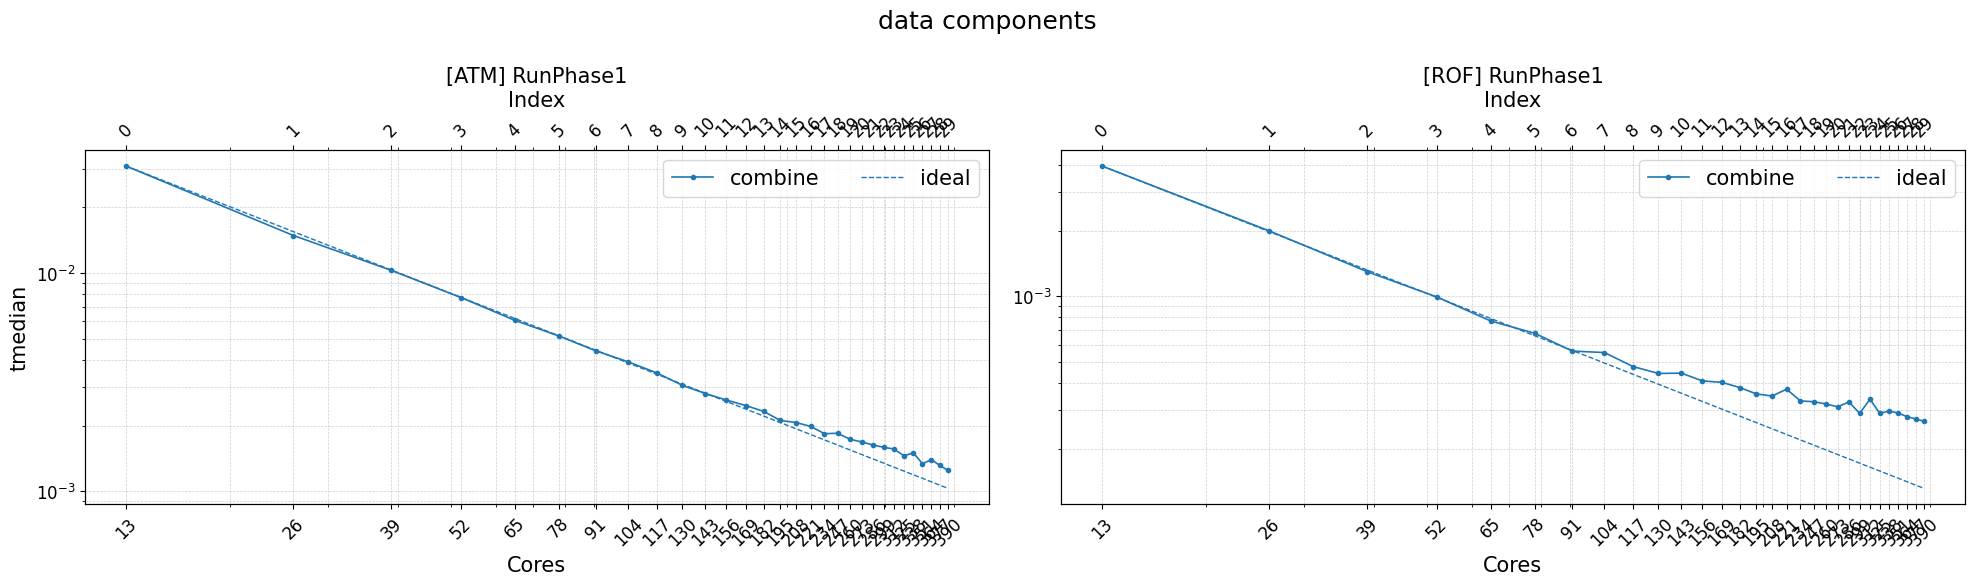

In [8]:
cores = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
pivot_used = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="data components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

In [9]:
pivot_used.head()

[ATM] RunPhase1 [ROF] RunPhase1
__output_name         combine         combine
cores                                        
13                   0.030929        0.003954
26                   0.014849        0.001992
39                   0.010276        0.001295
52                   0.007717        0.000992
65                   0.006067        0.000770

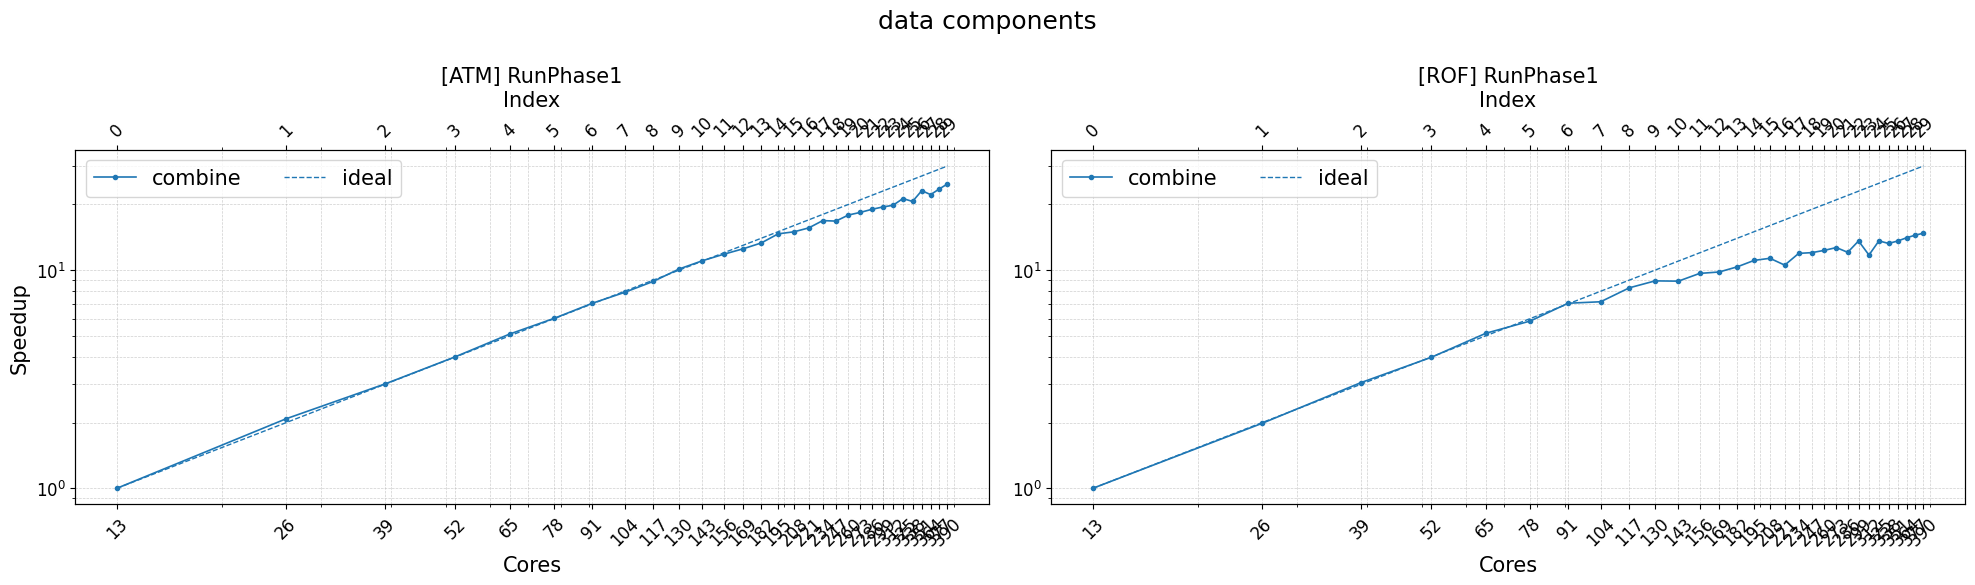

In [10]:
cores = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
pivot_used = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="data components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

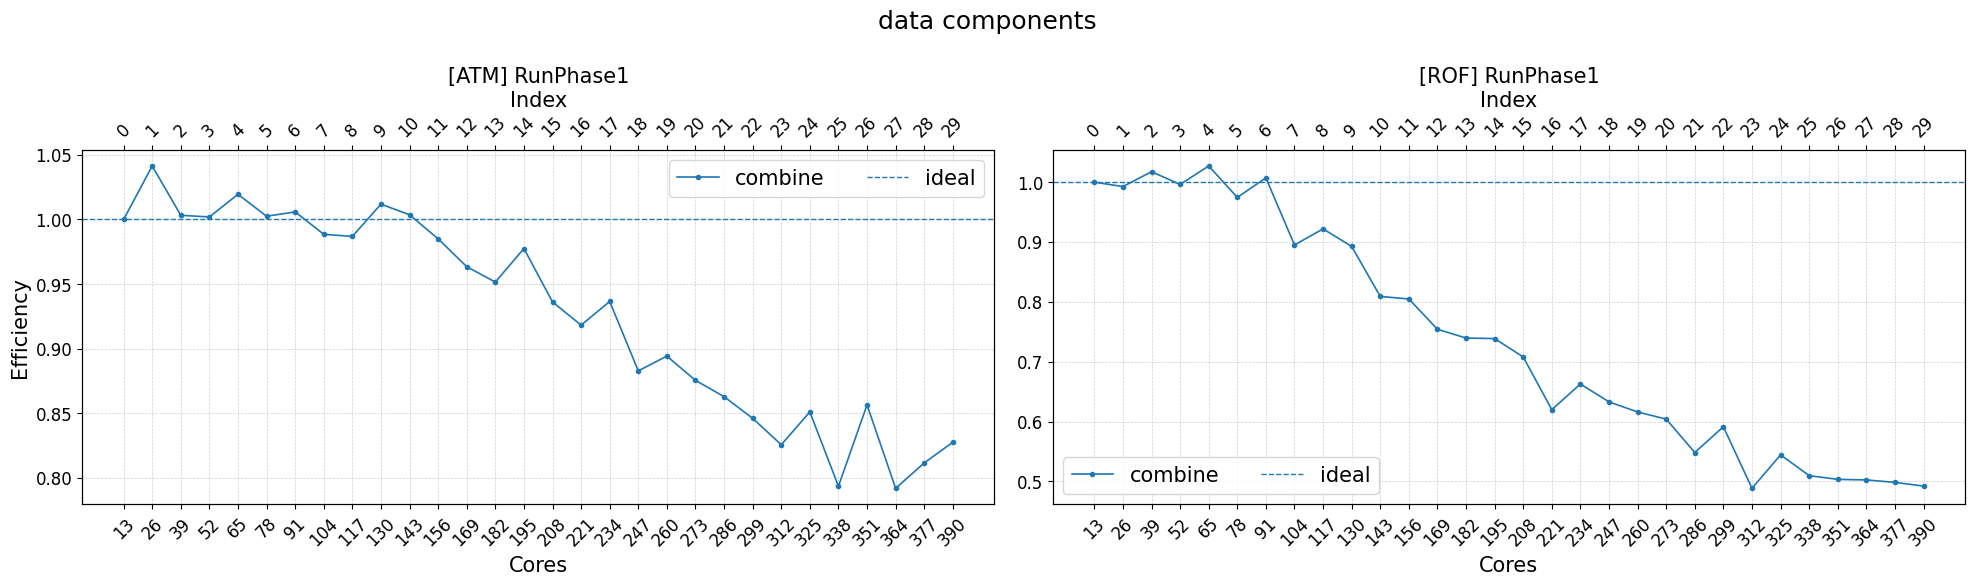

In [11]:
cores = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
pivot_used = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="data components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

In [12]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print, "
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write"
)
suffix = "med_comp"
count=30
base_prefix="med"
branch="med"
pets="0"
list_pets = [pets] * count
list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [13]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
]

post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    pets=pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=-1
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

In [14]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

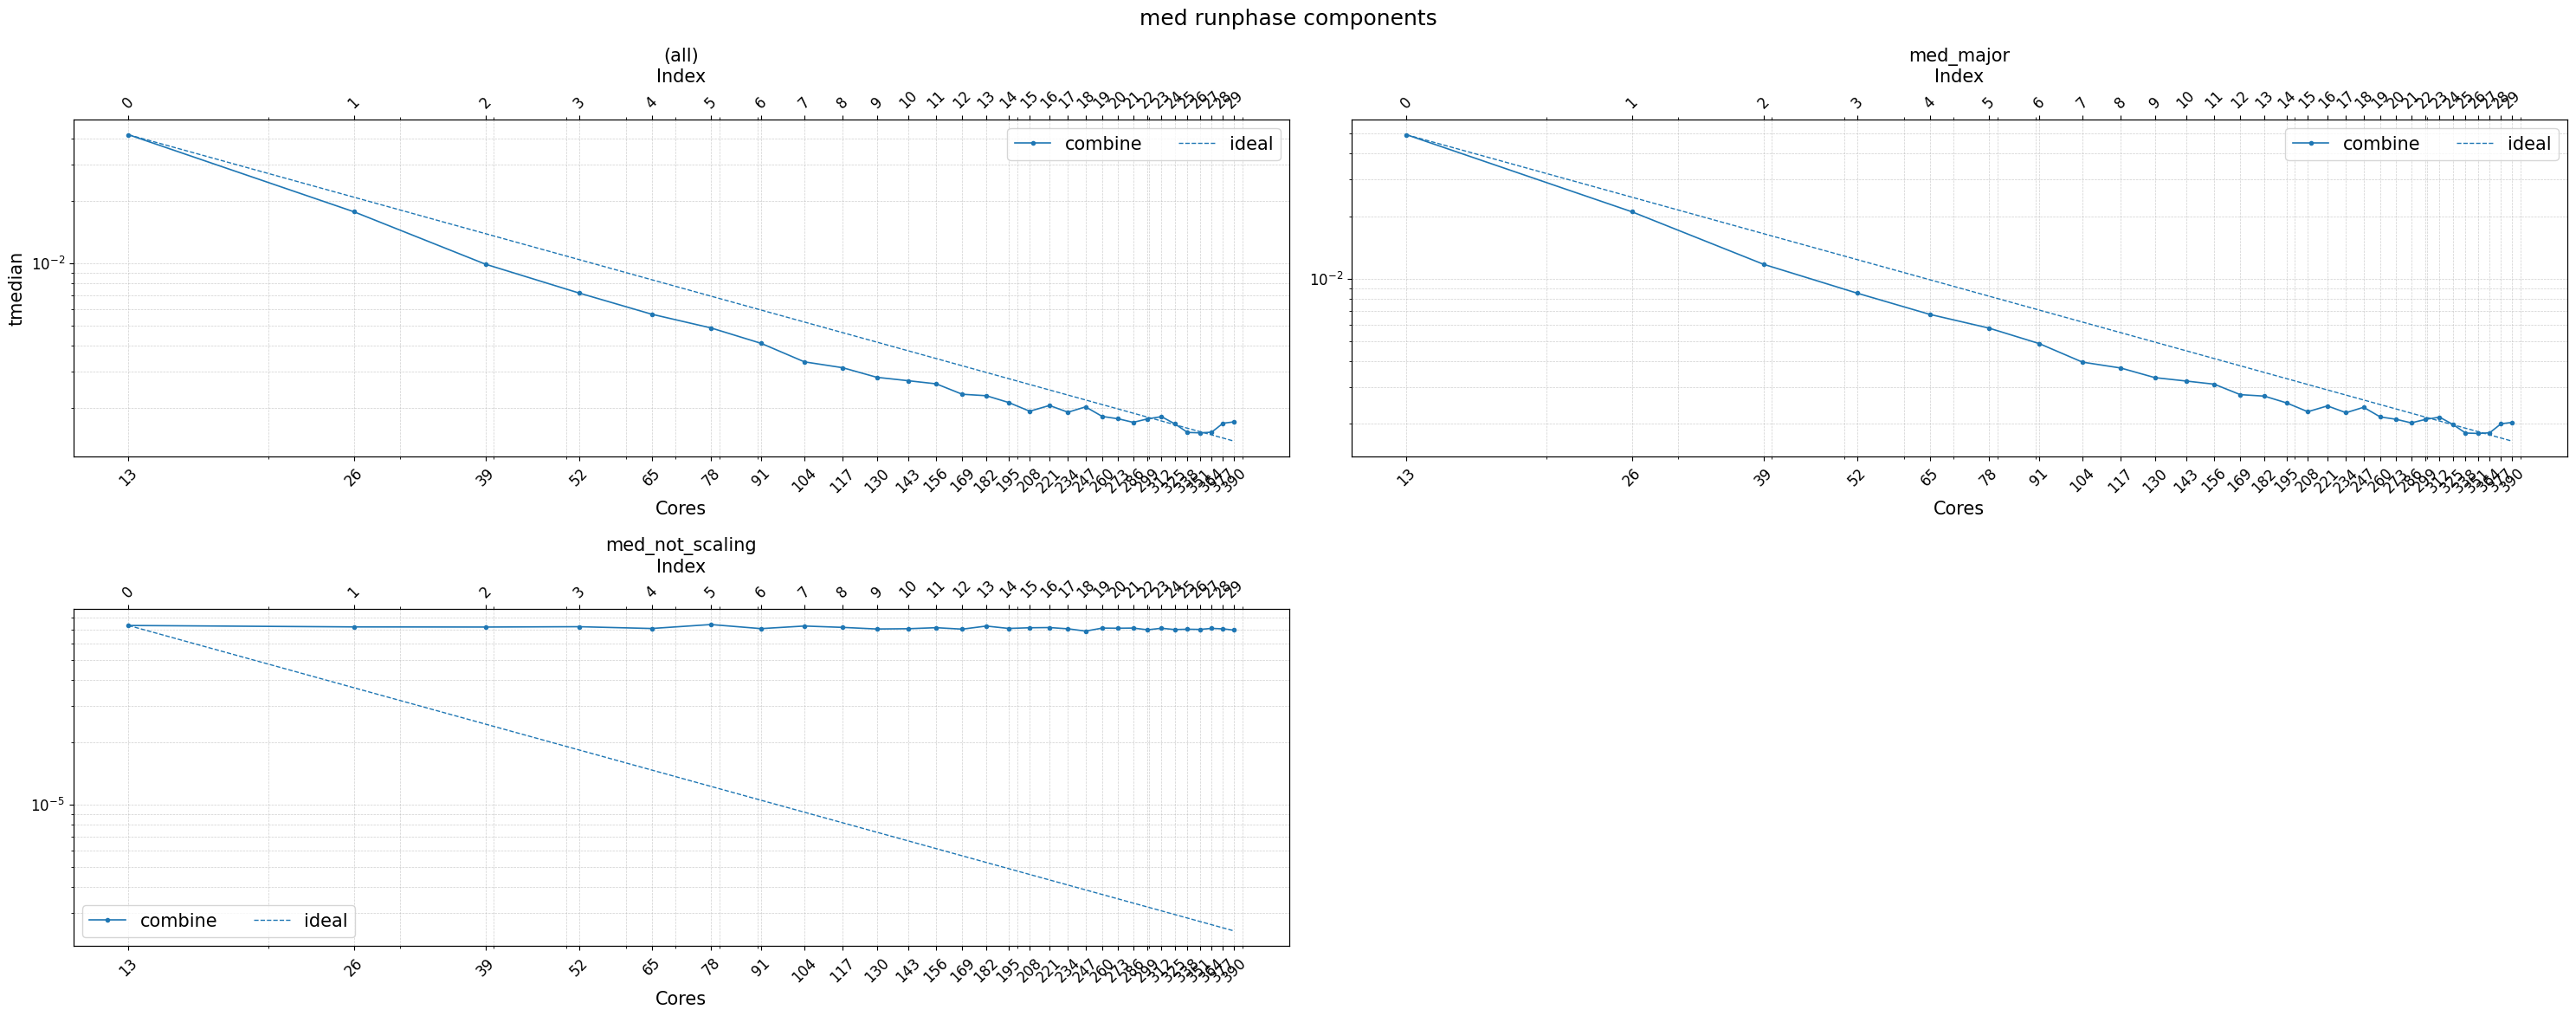

In [15]:
new_vars = {
    "med_major": [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_avg",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ocn_accum",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_aofluxes_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_prep_ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_post_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ocn",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_ocnalb_run",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_ice2med",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_atm",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_ice_med2ice",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_rof",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_accum",
    ],
    "med_not_scaling": [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_restart_write",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_profile",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_diag_print",
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED] med_phases_history_write",
    ],
}

pivot = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(30,12),
    new_vars=new_vars,
)


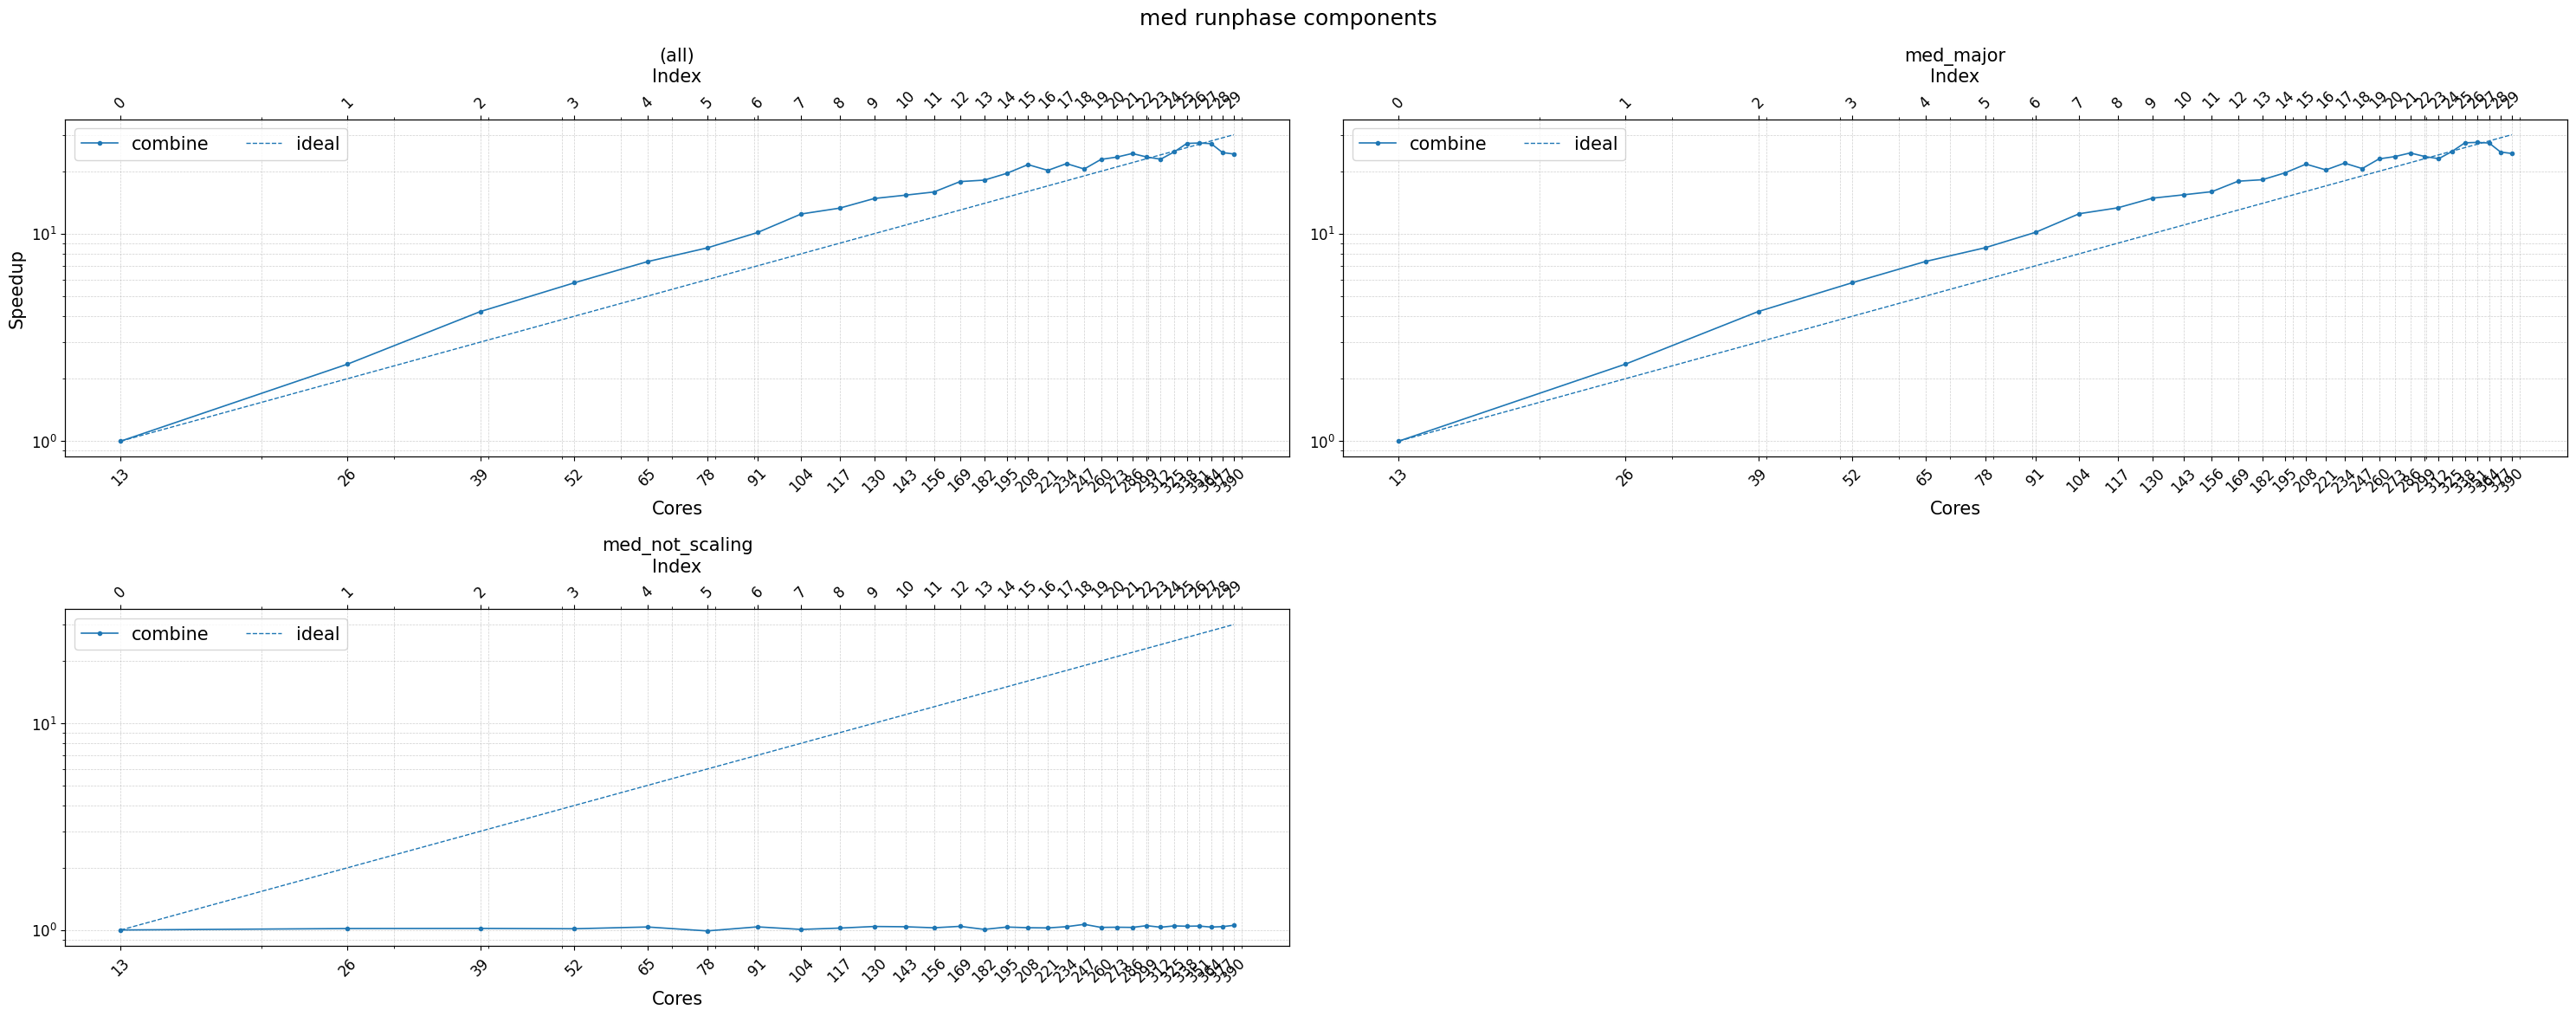

In [16]:
pivot = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(30,12),
    new_vars=new_vars,
)

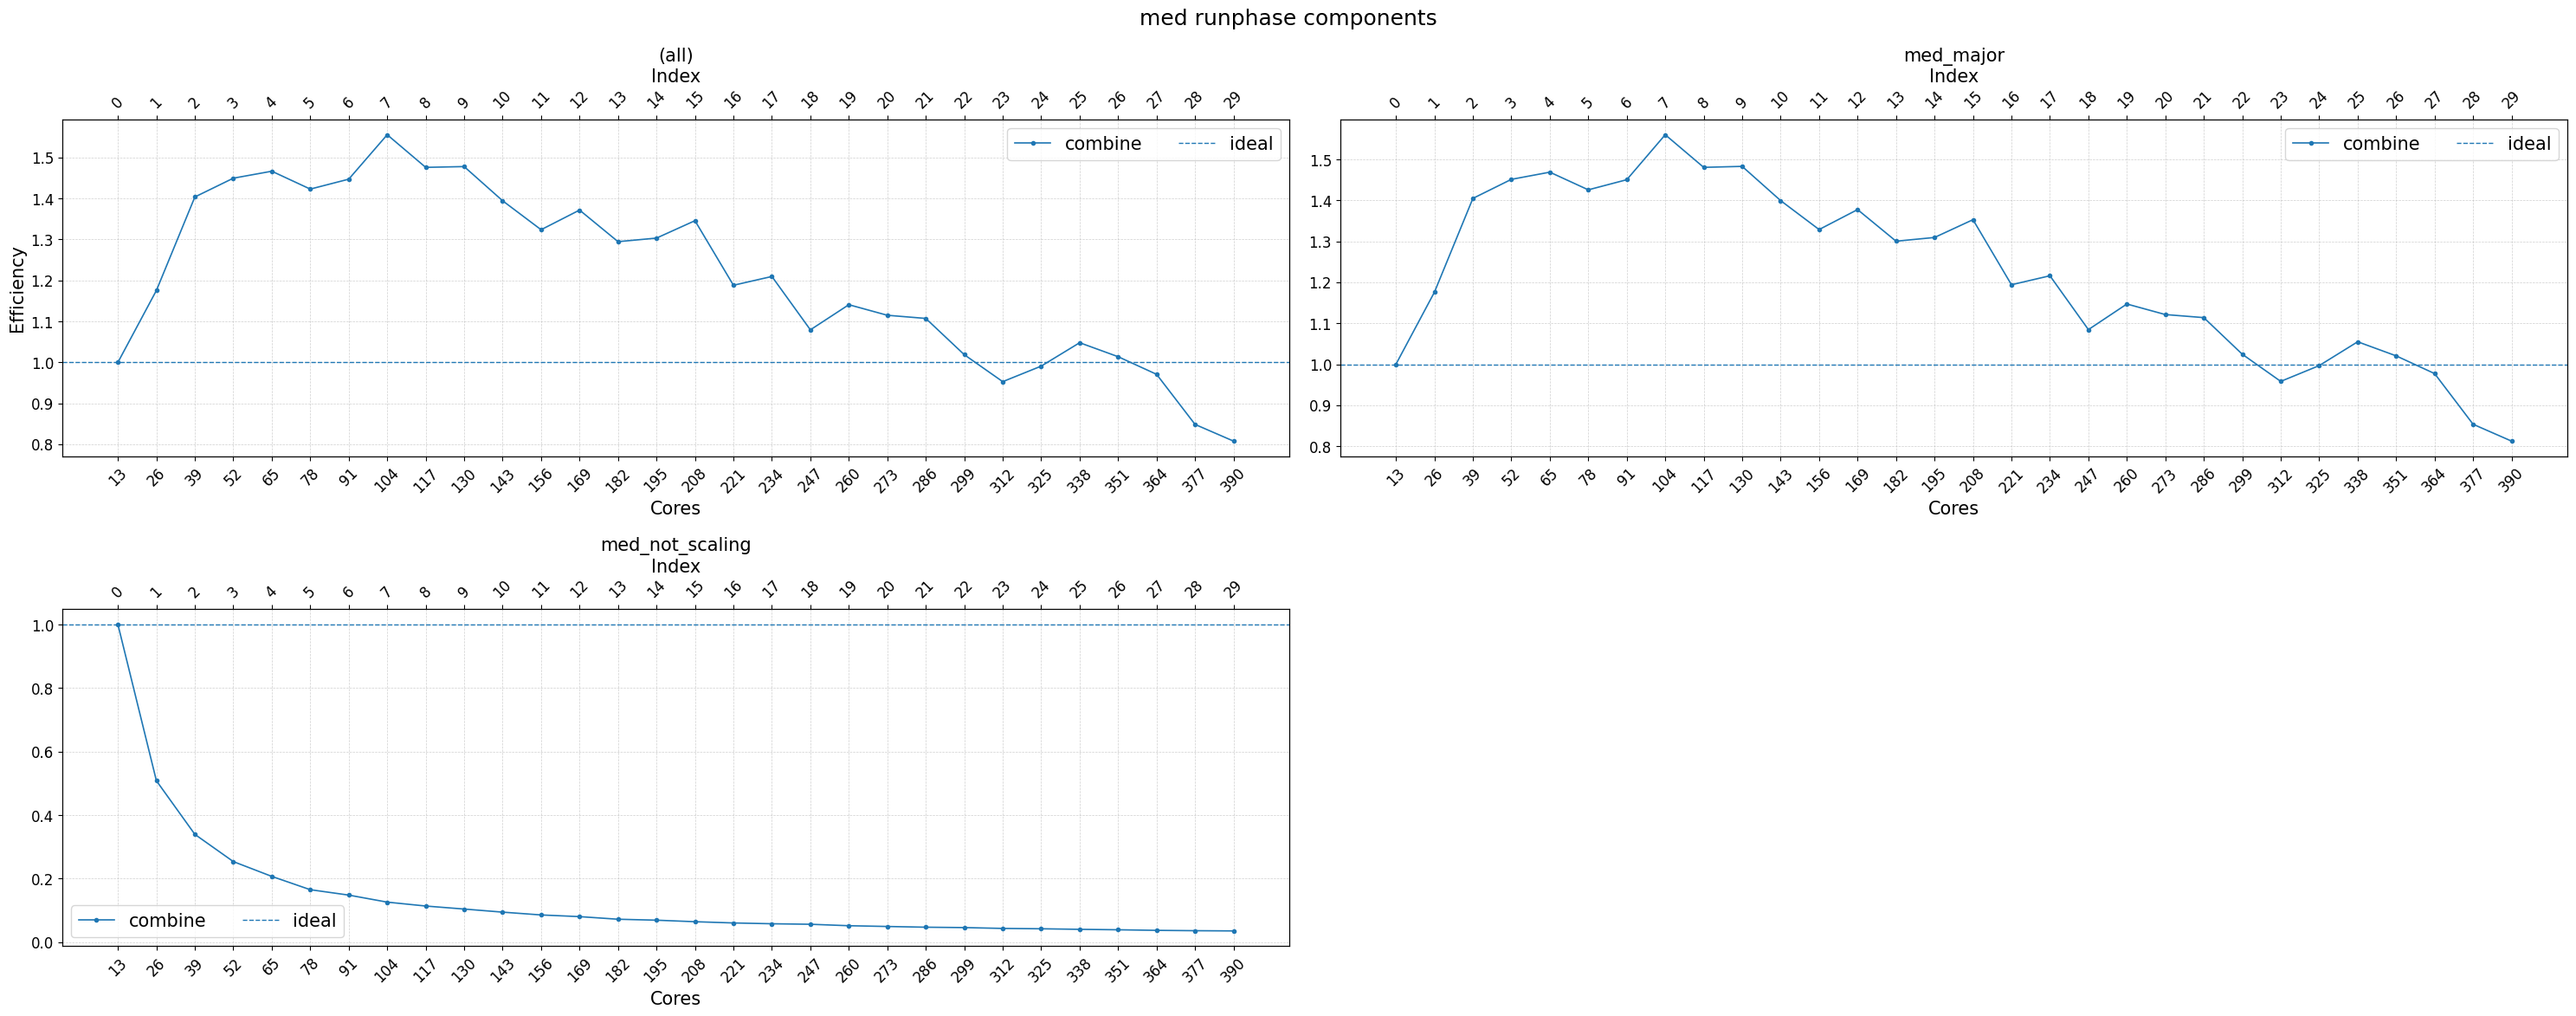

In [17]:
pivot = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med runphase components",
    #model_component=model_component,
    subplot_by_component=True,
    figsize=(30,12),
    new_vars=new_vars,
)

In [18]:
pivot

(all) med_major med_not_scaling
__output_name   combine   combine         combine
cores                                            
13             0.041607  0.049396        0.000073
26             0.017698  0.021004        0.000072
39             0.009880  0.011720        0.000072
52             0.007176  0.008508        0.000072
65             0.005674  0.006725        0.000071
78             0.004873  0.005774        0.000074
91             0.004107  0.004865        0.000071
104            0.003343  0.003957        0.000073
117            0.003132  0.003707        0.000072
130            0.002815  0.003331        0.000071
143            0.002713  0.003209        0.000071
156            0.002619  0.003098        0.000072
169            0.002333  0.002758        0.000071
182            0.002296  0.002713        0.000073
195            0.002128  0.002515        0.000071
208            0.001932  0.002282        0.000072
221            0.002060  0.002433        0.000072
234            0.001911  0.002257        0.000071
247            0.002029  0.002397        0.000069
260            0.001824  0.002153        0.000071
273            0.001777  0.002098        0.000071
286            0.001708  0.002016        0.000071
299            0.001776  0.002096        0.000070
312            0.001819  0.002148        0.000071
325            0.001680  0.001982        0.000070
338            0.001527  0.001801        0.000070
351            0.001520  0.001793        0.000070
364            0.001531  0.001805        0.000071
377            0.001691  0.001996        0.000071
390            0.001717  0.002027        0.000070

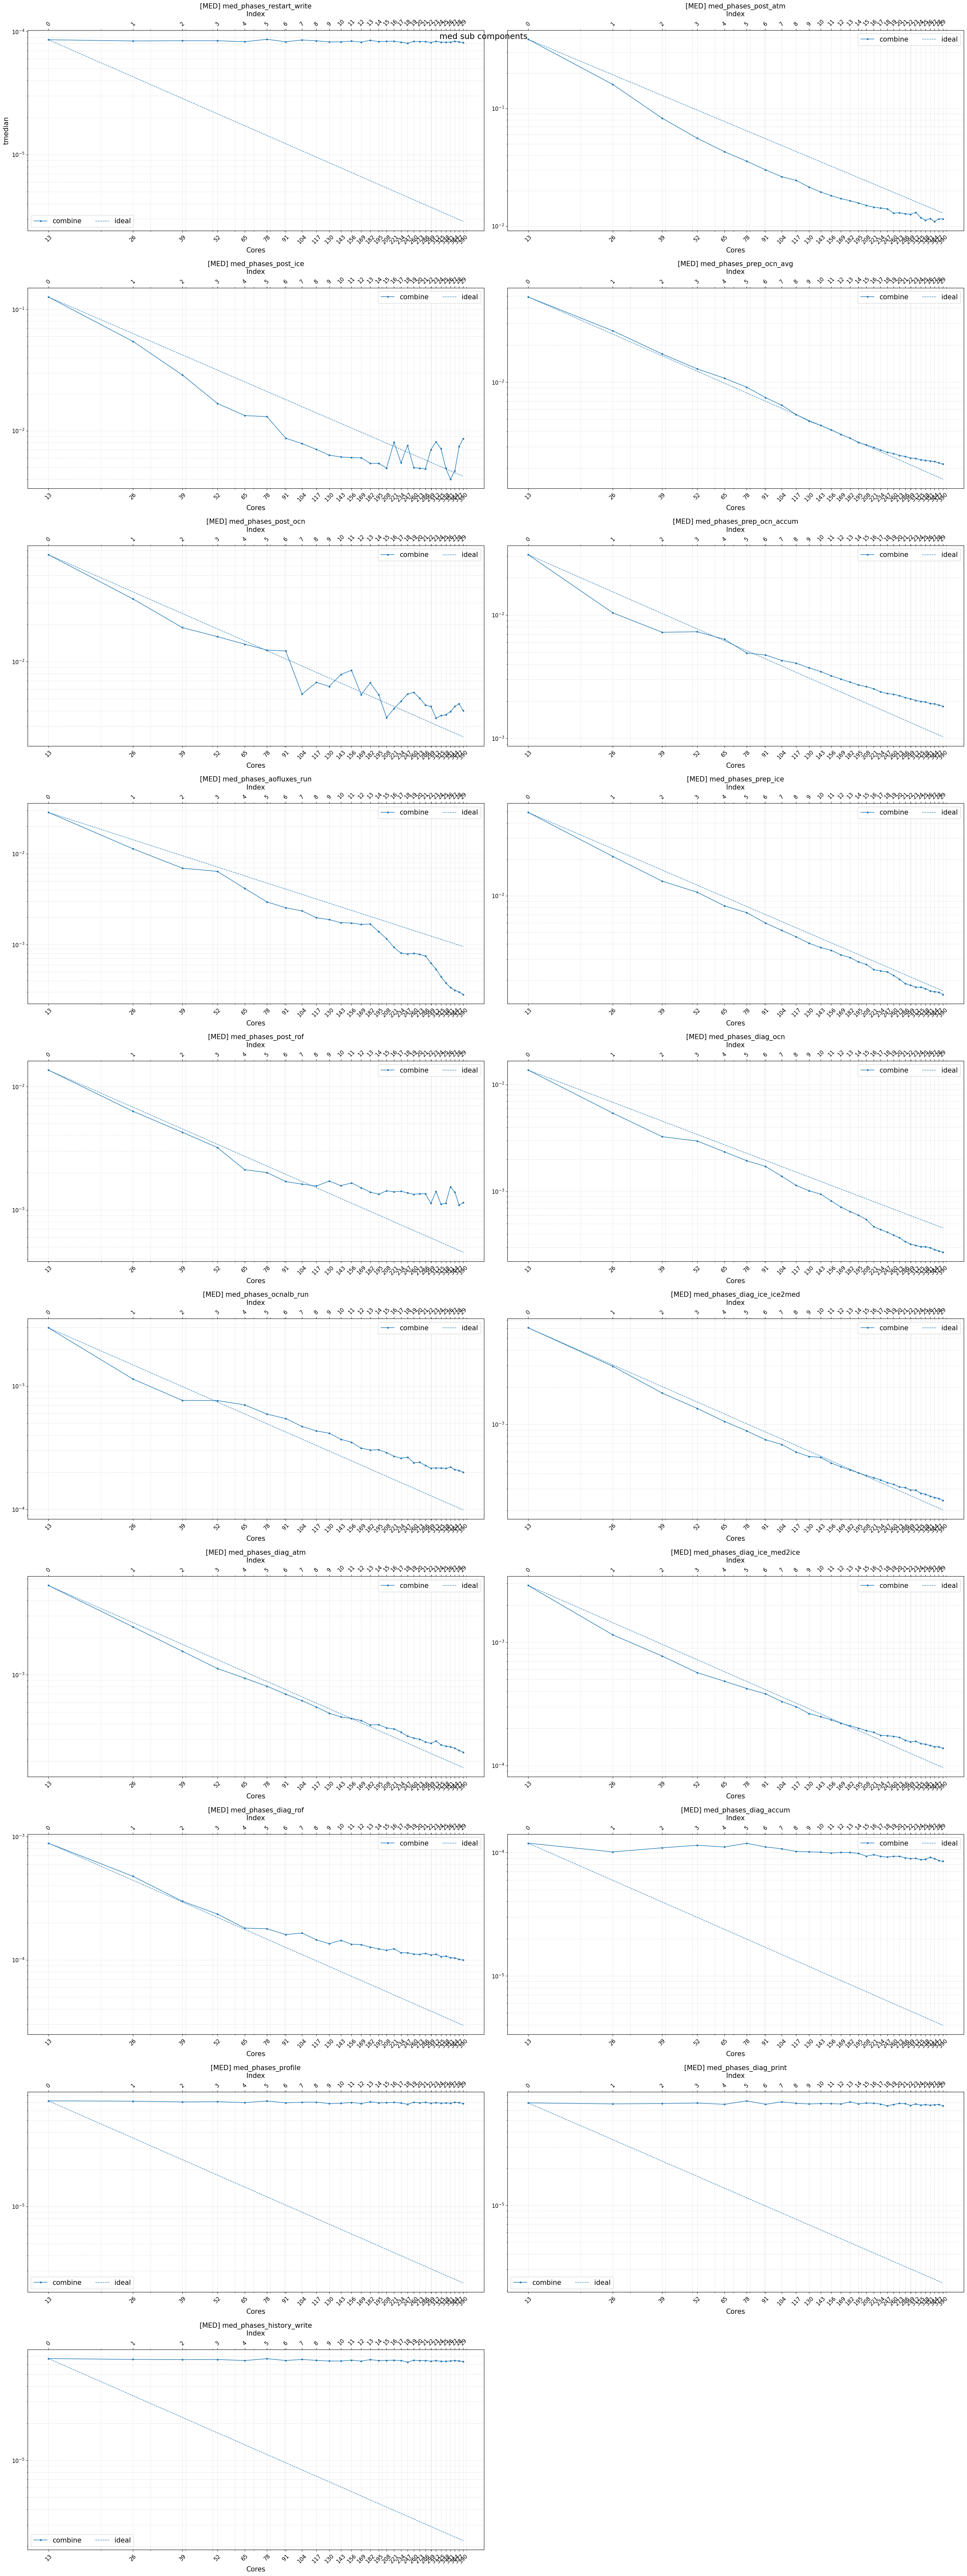

In [20]:
cores = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
pivot_used = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="med sub components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(30,80)
)

## med initialisation

In [21]:
model_component = (
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7"
)
suffix = "med_init_comp"
count=30
base_prefix="med"
branch="med"
pets="0"
list_pets = [pets] * count
list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [22]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7",
]
post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    pets=pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=-1
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

In [23]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

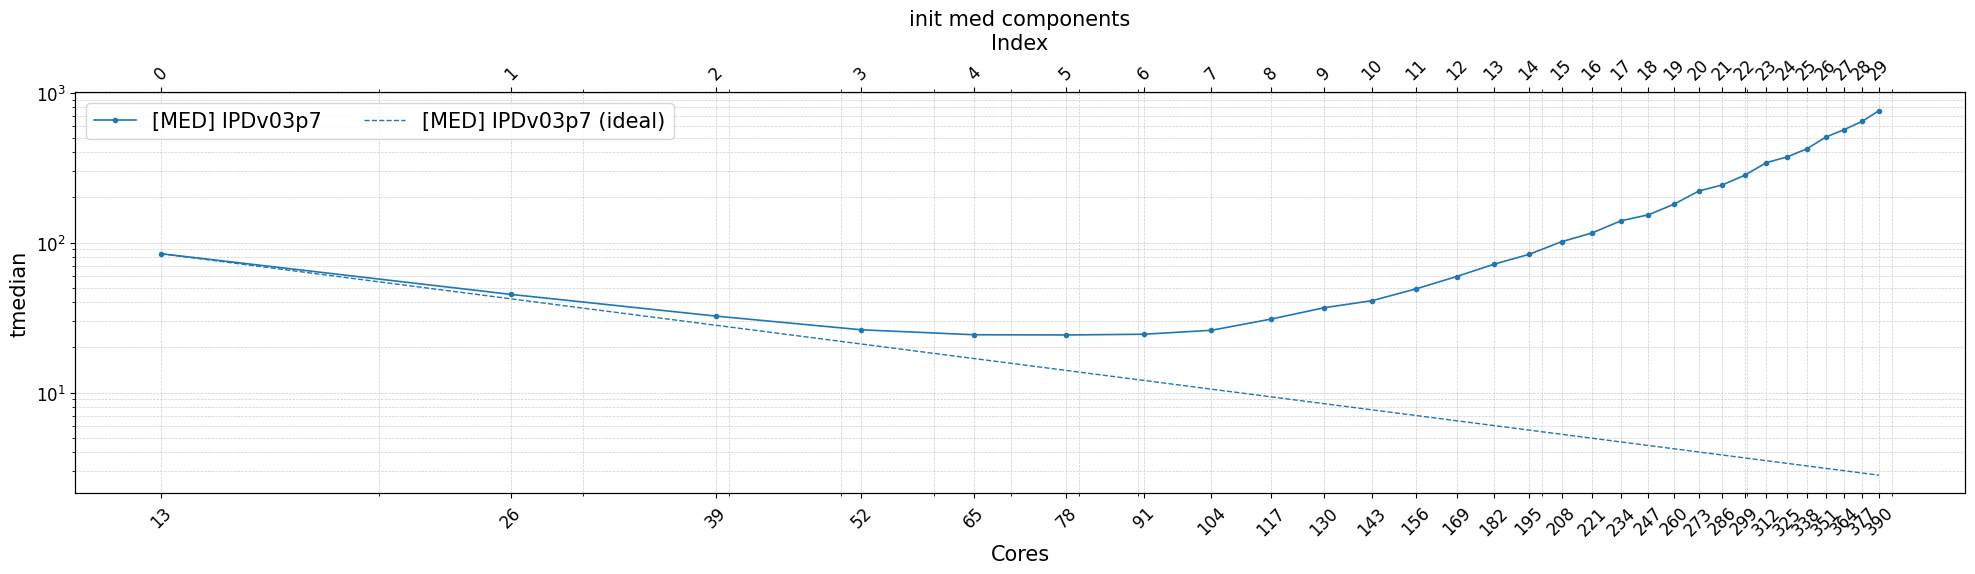

In [24]:
cores = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
pivot_used = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="init med components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

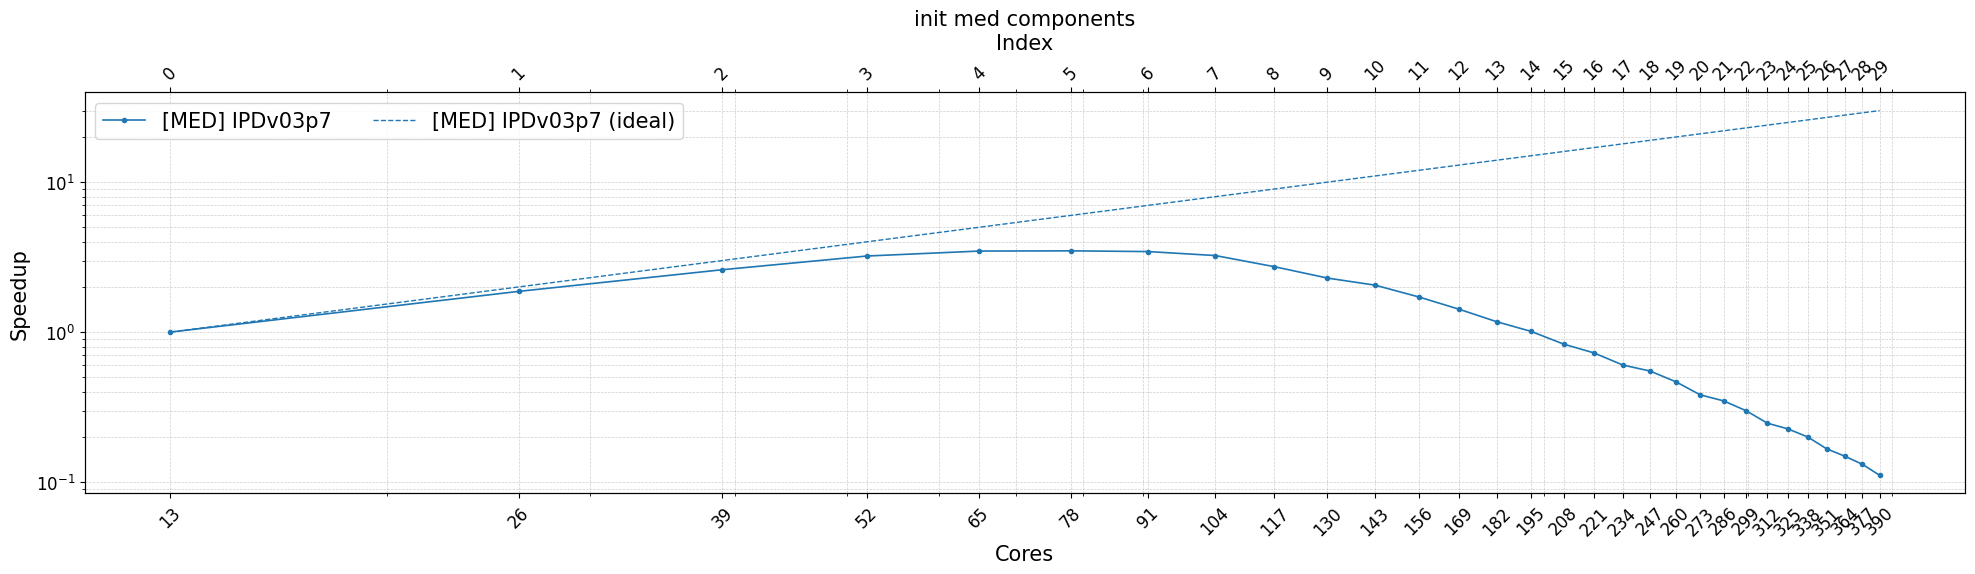

In [25]:
pivot_used = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="init med components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

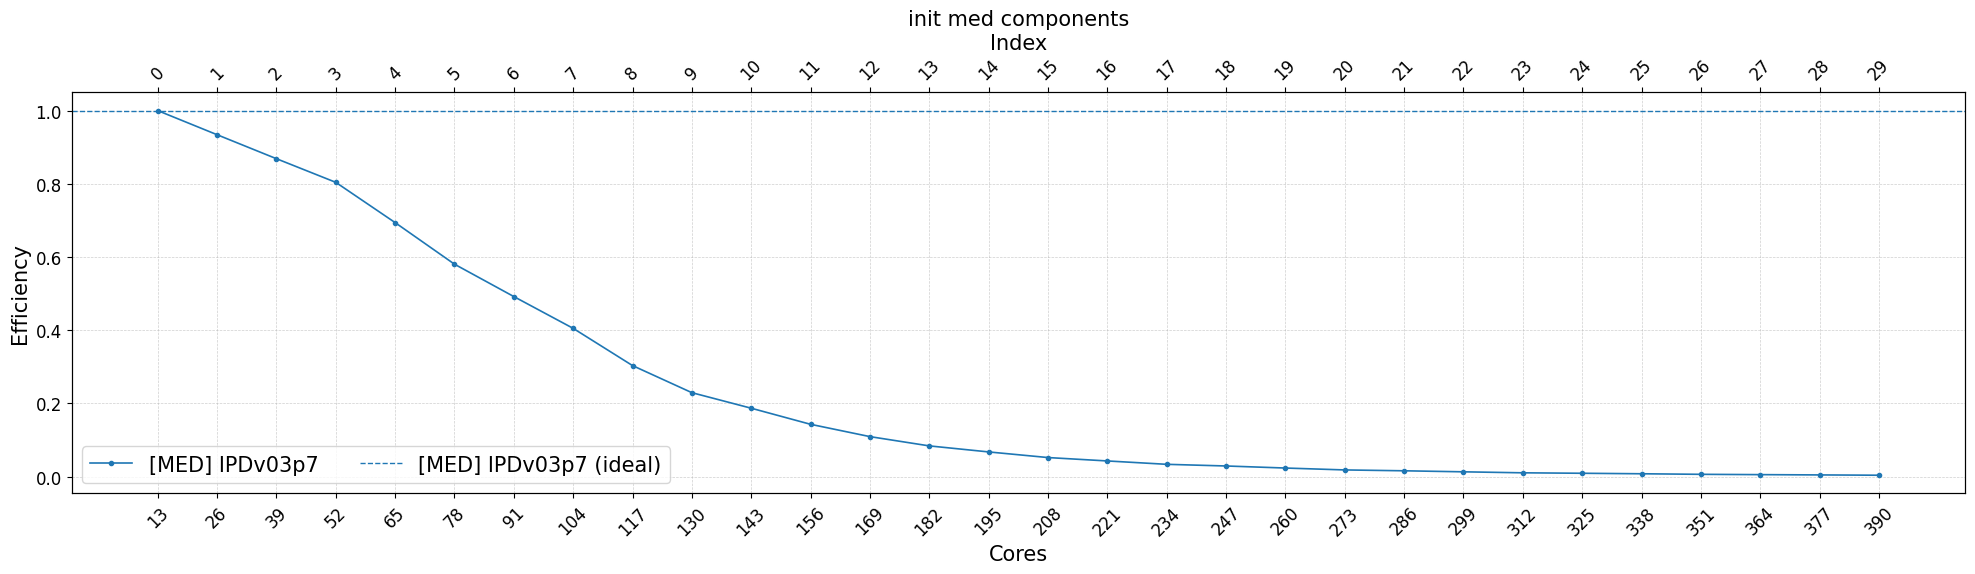

In [26]:
pivot_used = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="init med components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

## ice component

In [27]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1"
)

suffix = "ice_comp"
count=30
base_prefix="med"
branch="med"
pets="0"
list_pets = [pets] * count
list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [28]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1",
]
model_component = model_component
post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    pets=pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=-1
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

In [29]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

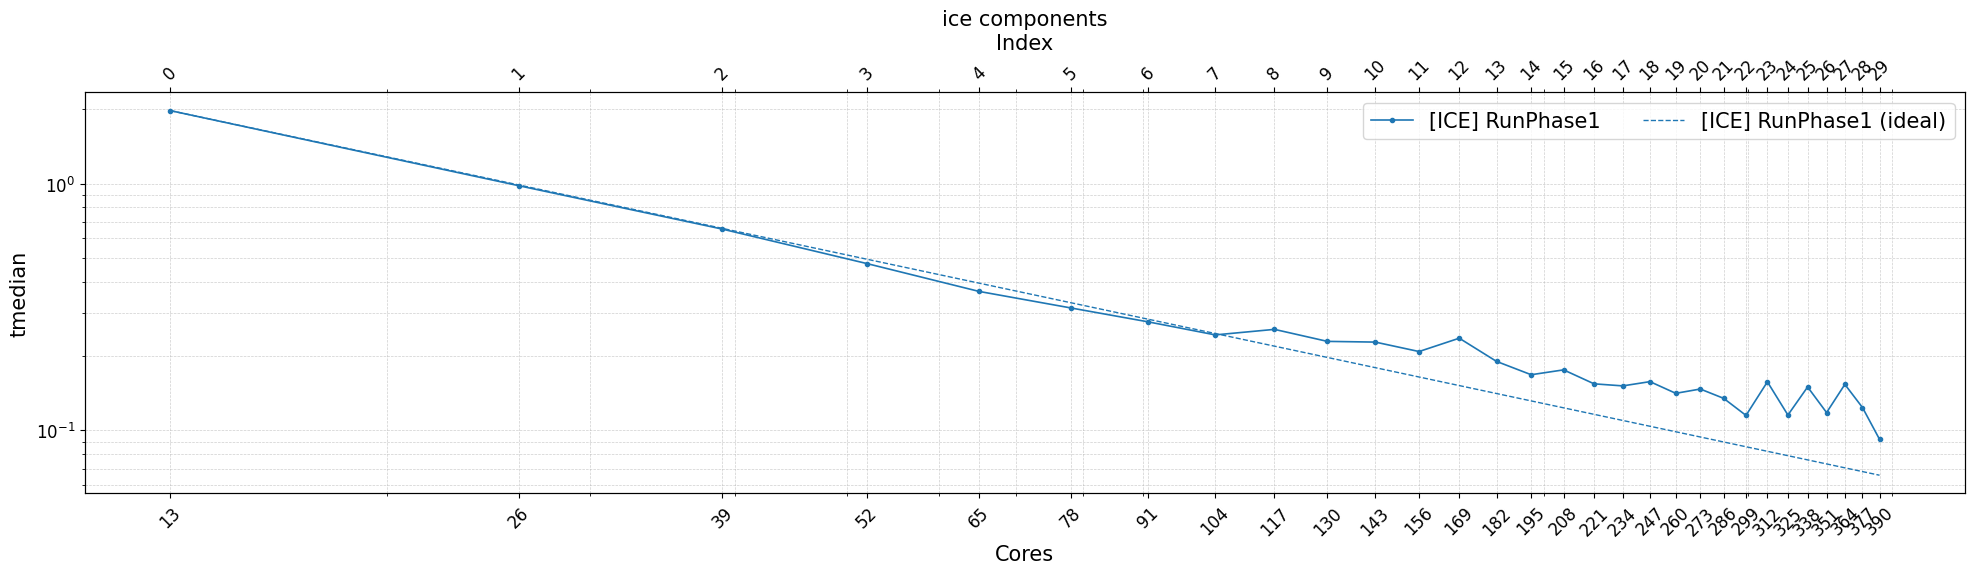

In [30]:
cores = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247, 260, 273, 286, 299, 312, 325, 338, 351, 364, 377, 390]
pivot_used = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ice components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

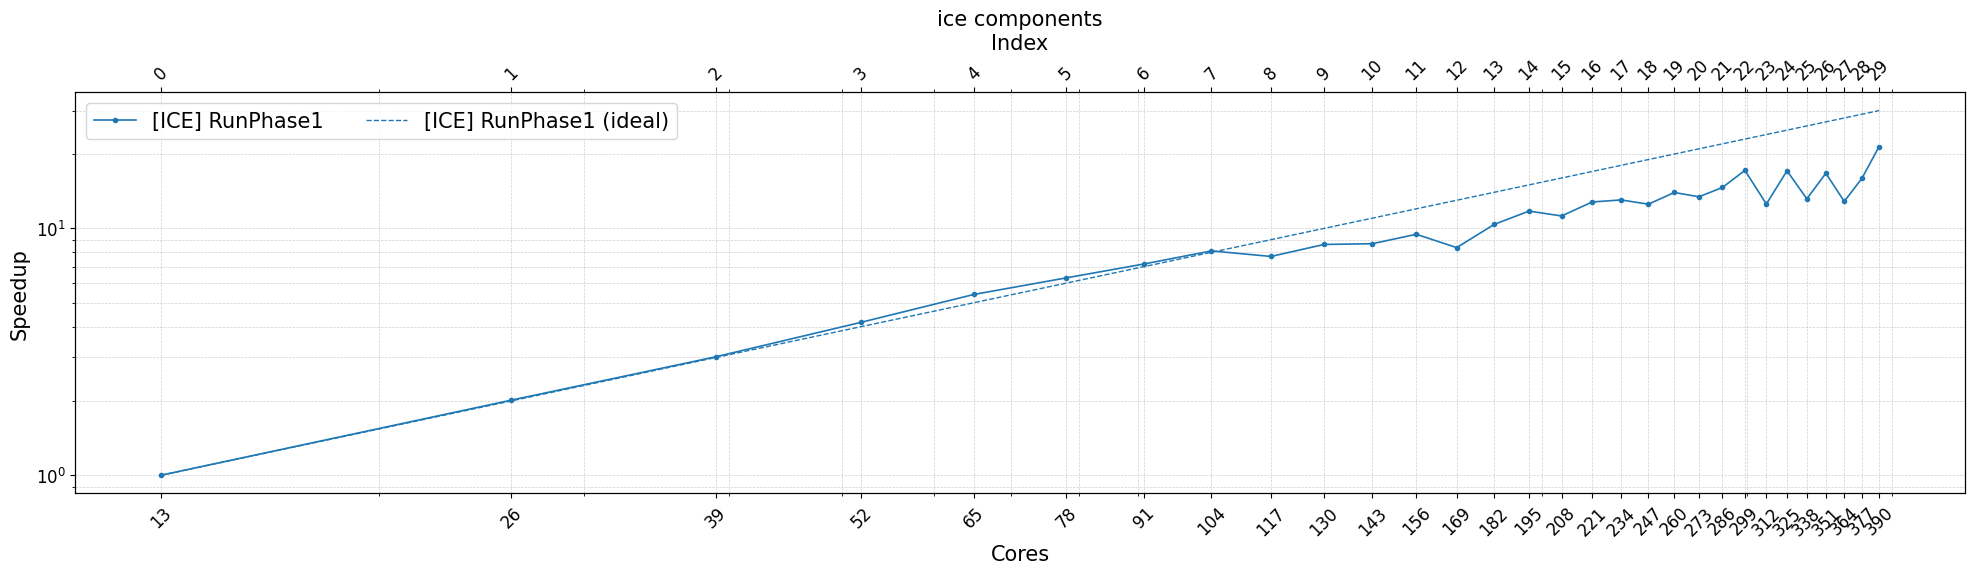

In [31]:
pivot_used = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ice components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

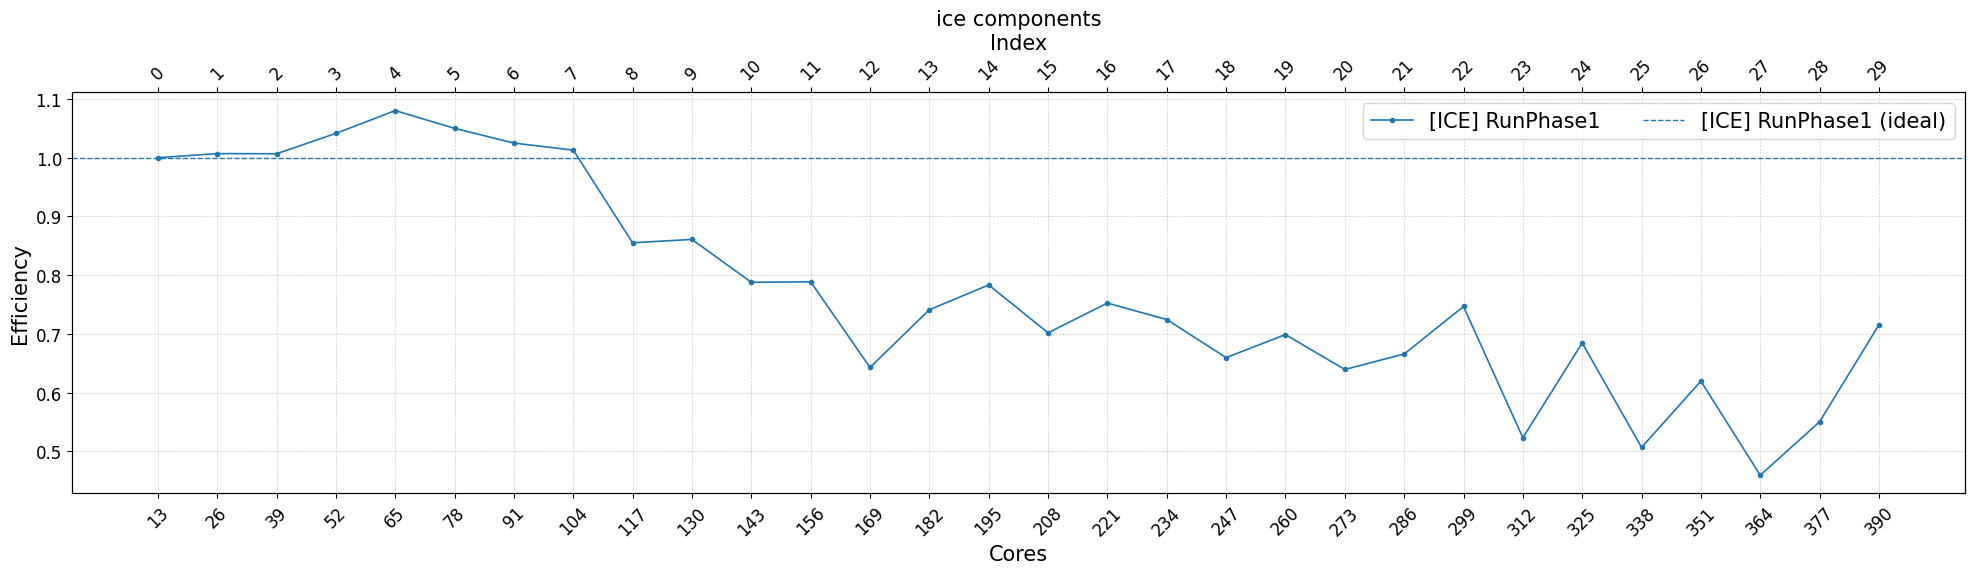

In [32]:
pivot_used = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="ice components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(20,6)
)

## ocn component

In [35]:
model_component = (
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1"
)

suffix = "ocn_comp"
count=50
base_prefix="mom6"
branch="mom6_only"
pets="52"
list_pets = [pets] * count
list_exact_path = [f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/{base_prefix}_{i}/{branch}/archive" for i in range(1,count+1)]
post_base_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"

run_config_med_dict = gen_run_config(
    post_base_path=post_base_path,
    model_component=model_component,
    base_prefix=base_prefix,
    count=count,
    list_pets=list_pets,
    list_exact_path=list_exact_path
)

run_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/run_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(run_config_med_dict, run_config_med_path)

In [36]:
post_base_path=f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}"
save_json_path = f"/g/data/tm70/ml0072/COMMON/git_repos/access-experiment-generator/performance_runnings_ncmas/om3/postprocessing_gen_om3_25km/{base_prefix}_{suffix}/med_json_{suffix}.json"
model_component = [
    "[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1",
]
model_component = model_component
post_config_med_dict = gen_postprocessing_config(
    post_base_path=post_base_path,
    base_prefix=base_prefix,
    count=count,
    model_component=model_component,
    pets=pets,
    save_json_path=save_json_path,
    stats_start_index=0,
    stats_end_index=None,
)
post_config_med_path = f"/g/data/tm70/ml0072/COMMON/git_repos/esmf-trace/examples/post_config_{base_prefix}_path_{suffix}.yaml"
write_yaml(post_config_med_dict, post_config_med_path)

In [37]:
df = pd.read_parquet(f"{post_base_path}/med_json_{suffix}_table.parquet")

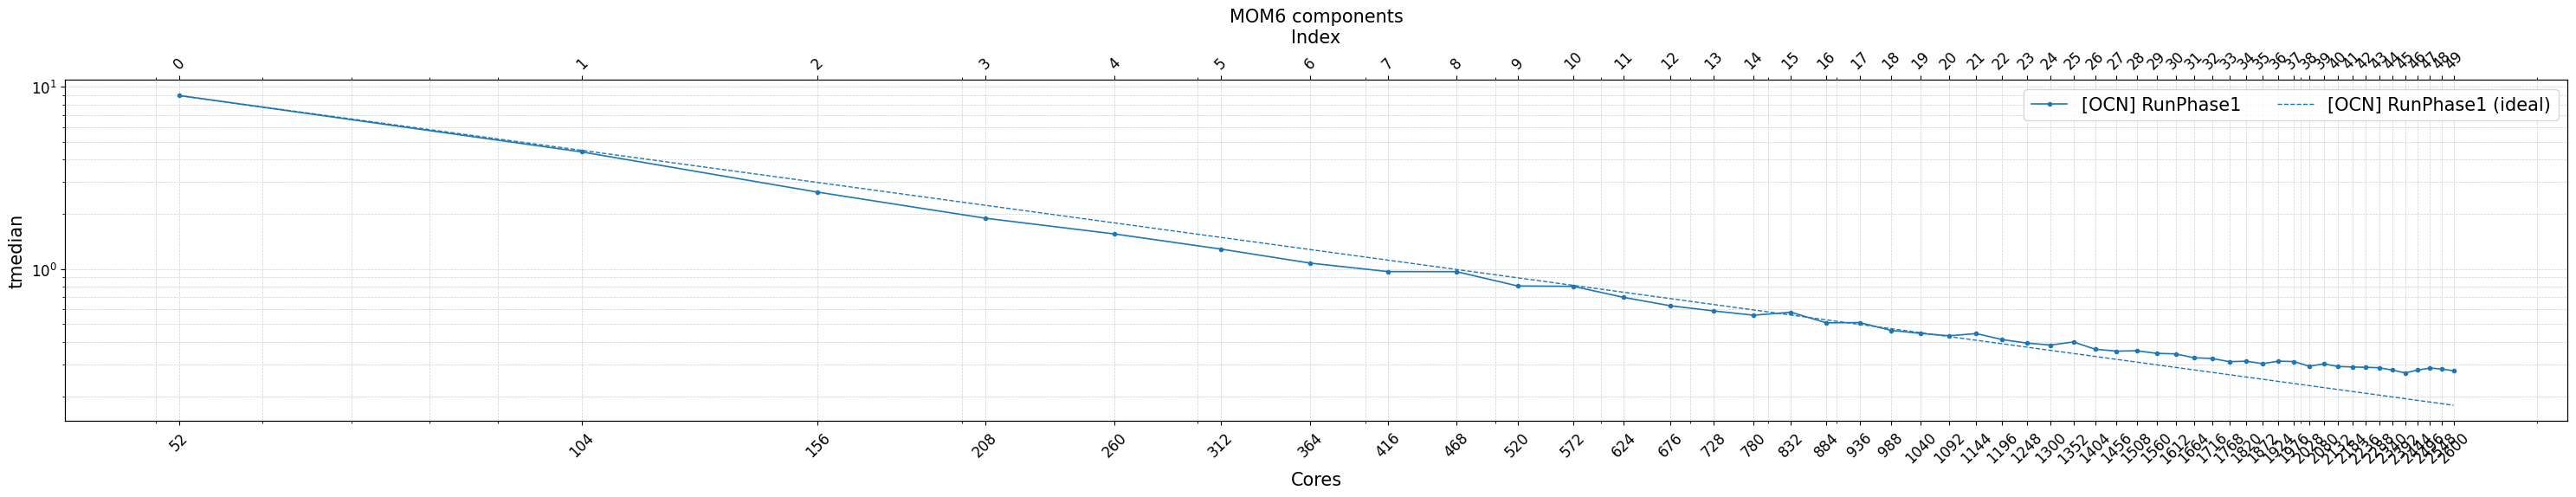

In [38]:
cores = [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572, 624, 676, 728, 780, 832, 884, 936, 988, 1040, 1092, 1144, 1196, 1248, 1300, 1352, 1404, 1456, 1508, 1560, 1612, 1664, 1716, 1768, 1820, 1872, 1924, 1976, 2028, 2080, 2132, 2184, 2236, 2288, 2340, 2392, 2444, 2496, 2548, 2600]
pivot_used = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MOM6 components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(30,6)
)

## This scaling is based on the avg timing, which is bad 

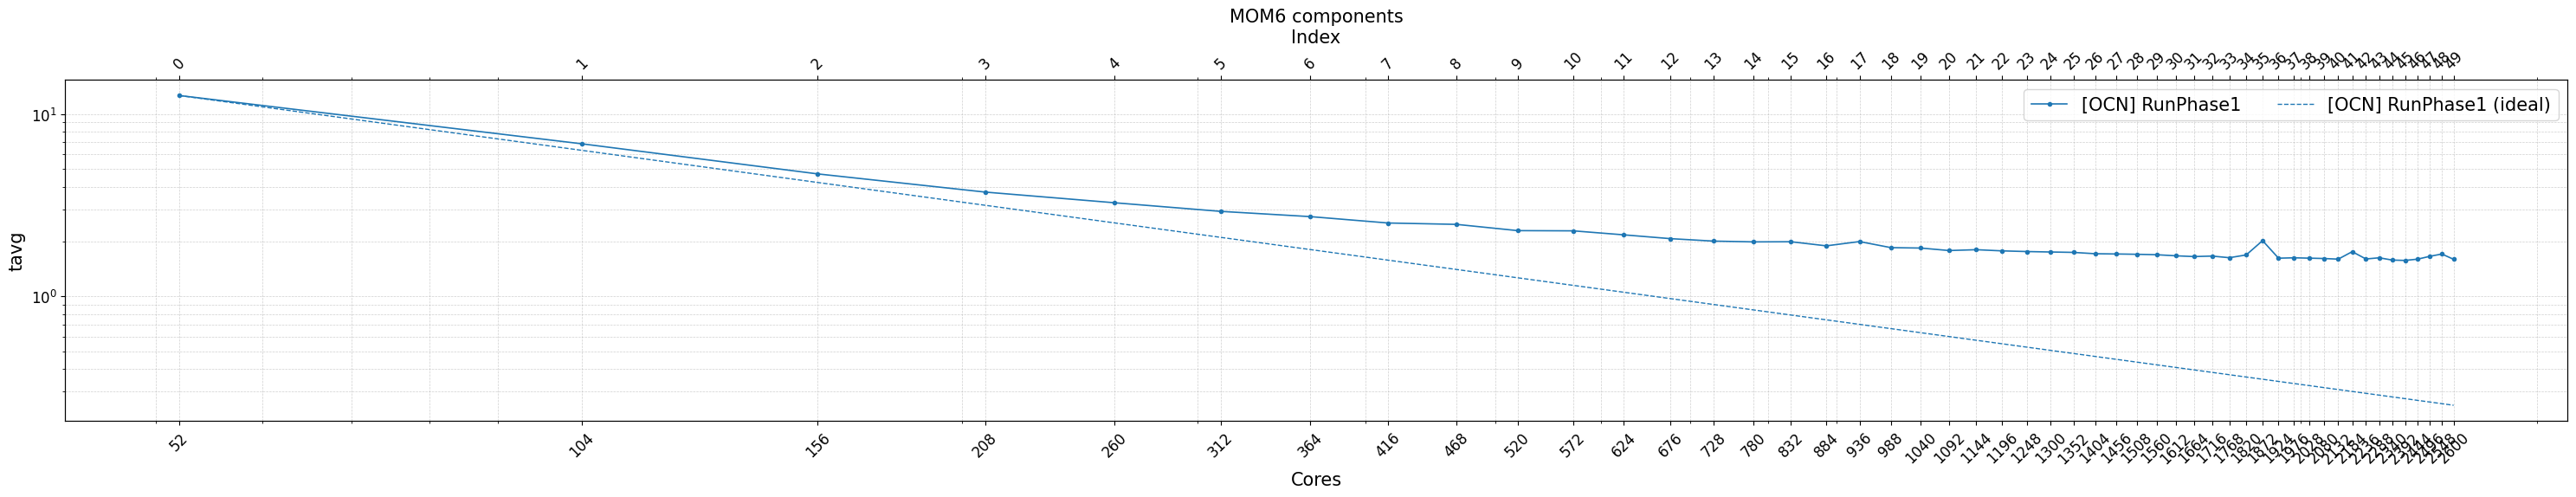

In [39]:
cores = [52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572, 624, 676, 728, 780, 832, 884, 936, 988, 1040, 1092, 1144, 1196, 1248, 1300, 1352, 1404, 1456, 1508, 1560, 1612, 1664, 1716, 1768, 1820, 1872, 1924, 1976, 2028, 2080, 2132, 2184, 2236, 2288, 2340, 2392, 2444, 2496, 2548, 2600]
pivot_used = plot_scaling(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tavg",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MOM6 components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(30,6)
)

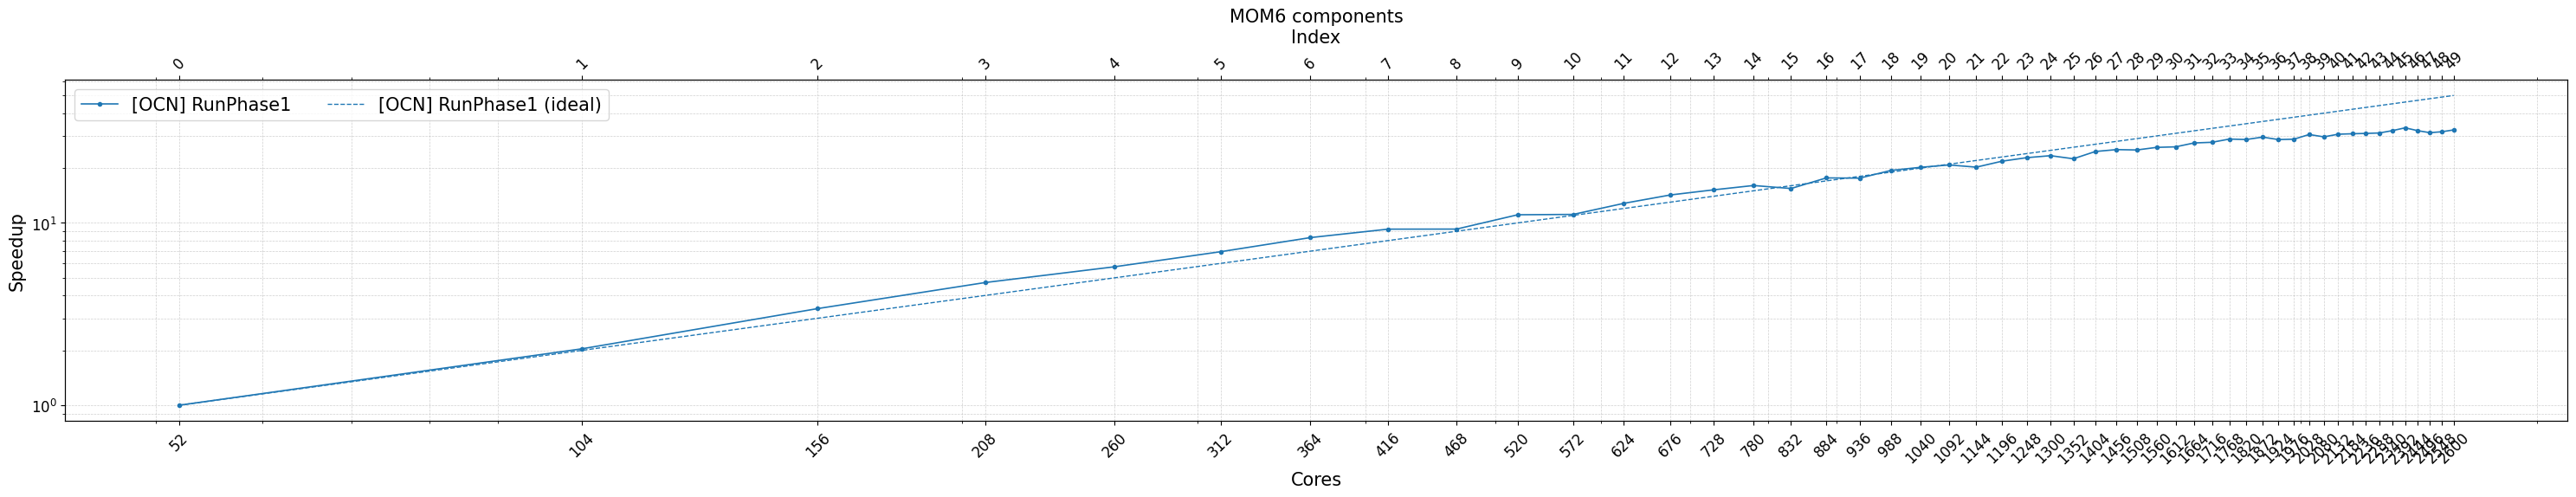

In [40]:
pivot_used = plot_speedup(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MOM6 components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(30,6)
)

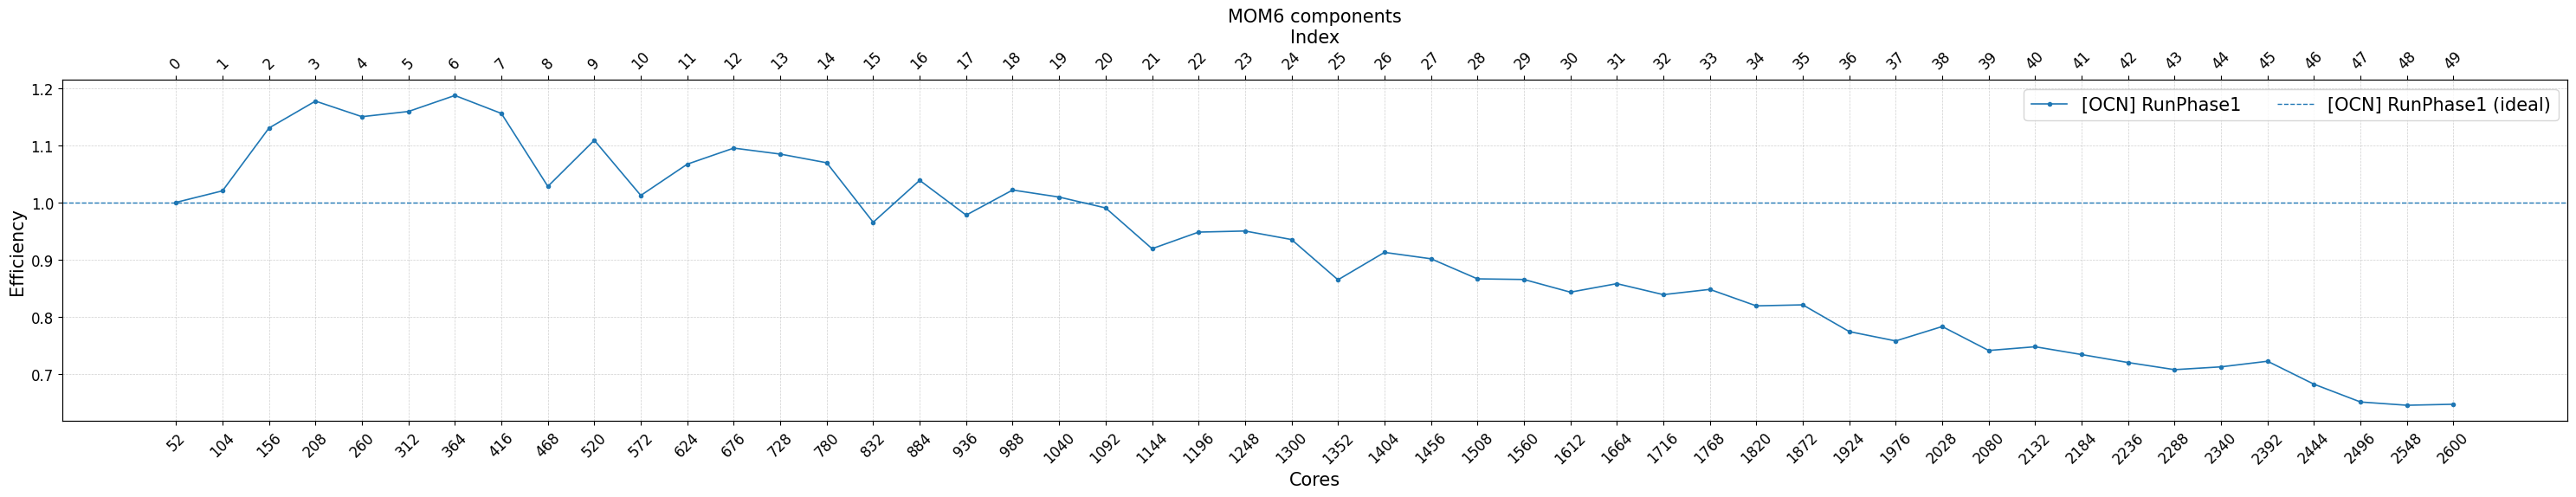

In [41]:
pivot_used = plot_efficiency(
    stats_df=df,
    cores=cores,
    base_prefix=base_prefix,
    ycol="tmedian",
    outputs=("combine",),
    output_for_ideal="combine",
    ideal_ref_index=0,
    title="MOM6 components",
    model_component=model_component,
    subplot_by_component=True,
    figsize=(30,6)
)